In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer



In [2]:
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [23]:
def runthebenchmark(hyperparameters):
    os.chdir('/home/dsinghvi/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 8","-c400 400 400 4 4 4 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float(value**3),output
    return 0;

In [24]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [33]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [34]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.qloguniform('setstripe-size',0,3,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,20,1)
    
}

In [40]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 165675008.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 720896.0}


In [36]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

In [ ]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/project/progress/active/result/gbm_trials-2.csv'

In [37]:
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/project/progress


In [38]:
from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

INFO:hyperopt.tpe:tpe_transform took 0.009525 seconds
INFO:hyperopt.tpe:TPE using 0 trials


rerun                                               
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '36700160'}, 'lfs': {'setstripe': {'size': 262144, 'count': 14}}}
outputS3D-IO 400-400-400-4-4-4-1 1845.95 7.63 4.23 514.40 22.89 45.56 0.05 0.12 262144 14 enable enable disable enable 36700160 

49.79898147838842                                   
123498.4142319717                                   
{'loss': 123498.4142319717, 'hyperparameters': {'cb_buffer_size': 36700160.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 14.0, 'setstripe-size': 262144.0}, 'iteration': 21, 'iteration_time': 55.23647459130734, 'status': 'ok'}
  5%|▌         | 1/20 [00:55<17:30, 55.26s/it, best loss: 123498.4142319717]

INFO:hyperopt.tpe:tpe_transform took 0.010116 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 123498.414232


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '312475648'}, 'lfs': {'setstripe': {'size': 589824, 'count': 17}}}
outputS3D-IO 400-400-400-4-4-4-1 456.22 7.63 17.12 1275.42 22.89 18.38 0.19 0.21 589824 17 enable disable disable enable 312475648 

35.5035305685841                                                            
44752.224524731726                                                          
{'loss': 44752.224524731726, 'hyperparameters': {'cb_buffer_size': 312475648.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 589824.0}, 'iteration': 22, 'iteration_time': 40.66693574748933, 'status': 'ok'}
 10%|█         | 2/20 [01:35<15:16, 50.89s/it, best loss: 44752.224524731726]

INFO:hyperopt.tpe:tpe_transform took 0.011786 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 44752.224525


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '415236096'}, 'lfs': {'setstripe': {'size': 851968, 'count': 19}}}
outputS3D-IO 400-400-400-4-4-4-1 1496.94 7.63 5.22 1317.53 22.89 17.79 0.18 0.34 851968 19 disable enable enable disable 415236096 

23.009774715592545                                                           
12182.519067188774                                                           
{'loss': 12182.519067188774, 'hyperparameters': {'cb_buffer_size': 415236096.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 19.0, 'setstripe-size': 851968.0}, 'iteration': 23, 'iteration_time': 28.658216703683138, 'status': 'ok'}
 15%|█▌        | 3/20 [02:04<12:31, 44.23s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010086 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '493879296'}, 'lfs': {'setstripe': {'size': 65536, 'count': 8}}}
outputS3D-IO 400-400-400-4-4-4-1 990.29 7.63 7.89 1079.02 22.89 21.72 0.20 0.13 65536 8 disable disable disable enable 493879296 

29.612551832436537                                                           
25967.342232806892                                                           
{'loss': 25967.342232806892, 'hyperparameters': {'cb_buffer_size': 493879296.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 8.0, 'setstripe-size': 65536.0}, 'iteration': 24, 'iteration_time': 34.884023296646774, 'status': 'ok'}
 20%|██        | 4/20 [02:39<11:03, 41.44s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.011719 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '423624704'}, 'lfs': {'setstripe': {'size': 327680, 'count': 2}}}
outputS3D-IO 400-400-400-4-4-4-1 1615.92 7.63 4.83 796.05 22.89 29.44 0.11 0.35 327680 2 enable disable disable enable 423624704 

34.27967347280092                                                            
40281.90763860556                                                            
{'loss': 40281.90763860556, 'hyperparameters': {'cb_buffer_size': 423624704.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 327680.0}, 'iteration': 25, 'iteration_time': 39.35419892705977, 'status': 'ok'}
 25%|██▌       | 5/20 [03:18<10:12, 40.82s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010059 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '351272960'}, 'lfs': {'setstripe': {'size': 655360, 'count': 0}}}
outputS3D-IO 400-400-400-4-4-4-1 956.93 7.63 8.16 570.02 22.89 41.12 0.05 0.47 655360 0 enable enable enable enable 351272960 

49.28501833797086                                                            
119713.95185358591                                                           
{'loss': 119713.95185358591, 'hyperparameters': {'cb_buffer_size': 351272960.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 0.0, 'setstripe-size': 655360.0}, 'iteration': 26, 'iteration_time': 54.298316166736186, 'status': 'ok'}
 30%|███       | 6/20 [04:13<10:28, 44.87s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010240 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '159383552'}, 'lfs': {'setstripe': {'size': 1048576, 'count': 12}}}
outputS3D-IO 400-400-400-4-4-4-1 1569.07 7.63 4.98 1027.01 22.89 22.82 0.16 0.18 1048576 12 enable enable disable disable 159383552 

27.802372286799102                                                           
21490.45266375671                                                            
{'loss': 21490.45266375671, 'hyperparameters': {'cb_buffer_size': 159383552.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 1048576.0}, 'iteration': 27, 'iteration_time': 33.36467974446714, 'status': 'ok'}
 35%|███▌      | 7/20 [04:46<08:58, 41.43s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010065 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '425721856'}, 'lfs': {'setstripe': {'size': 131072, 'count': 12}}}
outputS3D-IO 400-400-400-4-4-4-1 963.51 7.63 8.11 1235.99 22.89 18.96 0.11 0.34 131072 12 enable disable enable enable 425721856 

27.0730549952157                                                             
19843.20396405201                                                            
{'loss': 19843.20396405201, 'hyperparameters': {'cb_buffer_size': 425721856.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 12.0, 'setstripe-size': 131072.0}, 'iteration': 28, 'iteration_time': 32.39257223531604, 'status': 'ok'}
 40%|████      | 8/20 [05:19<07:44, 38.73s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.009878 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '468713472'}, 'lfs': {'setstripe': {'size': 458752, 'count': 16}}}
outputS3D-IO 400-400-400-4-4-4-1 993.94 7.63 7.86 1121.13 22.89 20.91 0.19 0.22 458752 16 enable disable disable disable 468713472 

28.76766260723361                                                            
23807.496534098387                                                           
{'loss': 23807.496534098387, 'hyperparameters': {'cb_buffer_size': 468713472.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 16.0, 'setstripe-size': 458752.0}, 'iteration': 29, 'iteration_time': 34.119107289239764, 'status': 'ok'}
 45%|████▌     | 9/20 [05:53<06:50, 37.35s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010136 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 12182.519067


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '530579456'}, 'lfs': {'setstripe': {'size': 262144, 'count': 6}}}
outputS3D-IO 400-400-400-4-4-4-1 941.22 7.63 8.30 1037.75 22.89 22.58 0.16 0.39 262144 6 disable disable disable disable 530579456 

30.8877677119069                                                             
29468.60433578361                                                            
{'loss': 29468.60433578361, 'hyperparameters': {'cb_buffer_size': 530579456.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 6.0, 'setstripe-size': 262144.0}, 'iteration': 30, 'iteration_time': 36.07652028184384, 'status': 'ok'}
 50%|█████     | 10/20 [06:29<06:09, 36.98s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010401 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '162529280'}, 'lfs': {'setstripe': {'size': 262144, 'count': 8}}}
outputS3D-IO 400-400-400-4-4-4-1 1161.04 7.63 6.73 1022.61 22.89 22.92 0.32 0.16 262144 8 enable enable enable enable 162529280 

29.650528628263437                                                            
26067.376336858604                                                            
{'loss': 26067.376336858604, 'hyperparameters': {'cb_buffer_size': 162529280.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 262144.0}, 'iteration': 31, 'iteration_time': 35.05339827015996, 'status': 'ok'}
 55%|█████▌    | 11/20 [07:04<05:27, 36.41s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010056 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '293601280'}, 'lfs': {'setstripe': {'size': 65536, 'count': 7}}}
outputS3D-IO 400-400-400-4-4-4-1 197.96 7.63 39.47 1174.42 22.89 19.96 0.11 0.33 65536 7 enable enable enable disable 293601280 

59.42641860689632                                                             
209864.35145933                                                               
{'loss': 209864.35145933, 'hyperparameters': {'cb_buffer_size': 293601280.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 65536.0}, 'iteration': 32, 'iteration_time': 64.55187961738557, 'status': 'ok'}
 60%|██████    | 12/20 [08:09<05:58, 44.86s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010532 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '55574528'}, 'lfs': {'setstripe': {'size': 917504, 'count': 2}}}
outputS3D-IO 400-400-400-4-4-4-1 1098.85 7.63 7.11 701.93 22.89 33.39 0.14 0.10 917504 2 enable enable disable disable 55574528 

40.503001296496876                                                            
66444.89472420939                                                             
{'loss': 66444.89472420939, 'hyperparameters': {'cb_buffer_size': 55574528.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 2.0, 'setstripe-size': 917504.0}, 'iteration': 33, 'iteration_time': 45.59903950616717, 'status': 'ok'}
 65%|██████▌   | 13/20 [08:54<05:15, 45.09s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010298 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '449839104'}, 'lfs': {'setstripe': {'size': 262144, 'count': 13}}}
outputS3D-IO 400-400-400-4-4-4-1 811.55 7.63 9.63 1406.12 22.89 16.67 0.08 0.30 262144 13 disable enable disable disable 449839104 

26.296934688505843                                                            
18185.087005404035                                                            
{'loss': 18185.087005404035, 'hyperparameters': {'cb_buffer_size': 449839104.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 262144.0}, 'iteration': 34, 'iteration_time': 31.67485585063696, 'status': 'ok'}
 70%|███████   | 14/20 [09:26<04:06, 41.08s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.009989 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '61865984'}, 'lfs': {'setstripe': {'size': 786432, 'count': 1}}}
outputS3D-IO 400-400-400-4-4-4-1 858.33 7.63 9.10 641.74 22.89 36.52 0.32 0.17 786432 1 disable disable enable enable 61865984 

45.62739790397727                                                             
94989.82902566409                                                             
{'loss': 94989.82902566409, 'hyperparameters': {'cb_buffer_size': 61865984.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 1.0, 'setstripe-size': 786432.0}, 'iteration': 35, 'iteration_time': 50.98324292805046, 'status': 'ok'}
 75%|███████▌  | 15/20 [10:17<03:40, 44.06s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010147 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '535822336'}, 'lfs': {'setstripe': {'size': 65536, 'count': 11}}}
outputS3D-IO 400-400-400-4-4-4-1 165.87 7.63 47.10 1268.27 22.89 18.48 0.26 0.36 65536 11 enable enable enable enable 535822336 

65.58524090806003                                                             
282109.9178082131                                                             
{'loss': 282109.9178082131, 'hyperparameters': {'cb_buffer_size': 535822336.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 11.0, 'setstripe-size': 65536.0}, 'iteration': 36, 'iteration_time': 71.24486501980573, 'status': 'ok'}
 80%|████████  | 16/20 [11:28<03:28, 52.22s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.009834 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '27262976'}, 'lfs': {'setstripe': {'size': 262144, 'count': 19}}}
outputS3D-IO 400-400-400-4-4-4-1 467.29 7.63 16.72 451.83 22.89 51.87 0.08 0.07 262144 19 disable enable disable disable 27262976 

68.59656899224784                                                             
322780.4198668749                                                             
{'loss': 322780.4198668749, 'hyperparameters': {'cb_buffer_size': 27262976.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 19.0, 'setstripe-size': 262144.0}, 'iteration': 37, 'iteration_time': 73.74052938167006, 'status': 'ok'}
 85%|████████▌ | 17/20 [12:42<02:56, 58.69s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010385 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '405798912'}, 'lfs': {'setstripe': {'size': 589824, 'count': 5}}}
outputS3D-IO 400-400-400-4-4-4-1 1745.82 7.63 4.48 1200.38 22.89 19.53 0.19 0.37 589824 5 enable disable disable enable 405798912 

24.001946215941395                                                            
13827.363333872569                                                            
{'loss': 13827.363333872569, 'hyperparameters': {'cb_buffer_size': 405798912.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 5.0, 'setstripe-size': 589824.0}, 'iteration': 38, 'iteration_time': 29.101918499916792, 'status': 'ok'}
 90%|█████████ | 18/20 [13:11<01:39, 49.82s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.009854 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '8388608'}, 'lfs': {'setstripe': {'size': 983040, 'count': 19}}}
outputS3D-IO 400-400-400-4-4-4-1 1151.86 7.63 6.78 322.63 22.89 72.64 0.08 0.04 983040 19 disable enable enable enable 8388608 

79.43394696303304                                                             
501208.50016751967                                                            
{'loss': 501208.50016751967, 'hyperparameters': {'cb_buffer_size': 8388608.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 19.0, 'setstripe-size': 983040.0}, 'iteration': 39, 'iteration_time': 84.50215366482735, 'status': 'ok'}
 95%|█████████▌| 19/20 [14:36<01:00, 60.24s/it, best loss: 12182.519067188774]

INFO:hyperopt.tpe:tpe_transform took 0.010058 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 12182.519067


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '44040192'}, 'lfs': {'setstripe': {'size': 131072, 'count': 12}}}
outputS3D-IO 400-400-400-4-4-4-1 1563.40 7.63 5.00 561.69 22.89 41.73 0.08 0.06 131072 12 disable enable disable disable 44040192 

46.72758285589515                                                             
102028.13513479785                                                            
{'loss': 102028.13513479785, 'hyperparameters': {'cb_buffer_size': 44040192.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 131072.0}, 'iteration': 40, 'iteration_time': 51.75613302178681, 'status': 'ok'}
100%|██████████| 20/20 [15:27<00:00, 57.70s/it, best loss: 12182.519067188774]


In [41]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 396.0, 'romio_cb_read': 0, 'romio_cb_write': 1, 'romio_ds_read': 1, 'romio_ds_write': 0, 'setstripe-count': 19.0, 'setstripe-size': 13.0}


In [42]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,13827.363334,"{'cb_buffer_size': 405798912.0, 'romio_cb_read...",38,29.101918,S3D-IO 400-400-400-4-4-4-1 1745.82 7.63 4.48 1...
1,18185.087005,"{'cb_buffer_size': 449839104.0, 'romio_cb_read...",34,31.674856,S3D-IO 400-400-400-4-4-4-1 811.55 7.63 9.63 14...
2,19843.203964,"{'cb_buffer_size': 425721856.0, 'romio_cb_read...",28,32.392572,S3D-IO 400-400-400-4-4-4-1 963.51 7.63 8.11 12...
3,21490.452664,"{'cb_buffer_size': 159383552.0, 'romio_cb_read...",27,33.364680,S3D-IO 400-400-400-4-4-4-1 1569.07 7.63 4.98 1...
4,23807.496534,"{'cb_buffer_size': 468713472.0, 'romio_cb_read...",29,34.119107,S3D-IO 400-400-400-4-4-4-1 993.94 7.63 7.86 11...


In [43]:
type(results)


pandas.core.frame.DataFrame

In [44]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
print(results.loc[0,'output'])

{'cb_buffer_size': 405798912.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 5.0, 'setstripe-size': 589824.0}
S3D-IO 400-400-400-4-4-4-1 1745.82 7.63 4.48 1200.38 22.89 19.53 0.19 0.37 589824 5 enable disable disable enable 405798912 



In [45]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']
bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,4.05799e+08,disable,enable,enable,disable,5,589824,29.101918,13827.363334,38,S3D-IO 400-400-400-4-4-4-1 1745.82 7.63 4.48 1...
1,4.49839e+08,disable,disable,disable,enable,13,262144,31.674856,18185.087005,34,S3D-IO 400-400-400-4-4-4-1 811.55 7.63 9.63 14...
2,4.25722e+08,enable,enable,enable,disable,12,131072,32.392572,19843.203964,28,S3D-IO 400-400-400-4-4-4-1 963.51 7.63 8.11 12...
3,1.59384e+08,disable,disable,enable,enable,12,1.04858e+06,33.364680,21490.452664,27,S3D-IO 400-400-400-4-4-4-1 1569.07 7.63 4.98 1...
4,4.68713e+08,disable,disable,enable,disable,16,458752,34.119107,23807.496534,29,S3D-IO 400-400-400-4-4-4-1 993.94 7.63 7.86 11...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


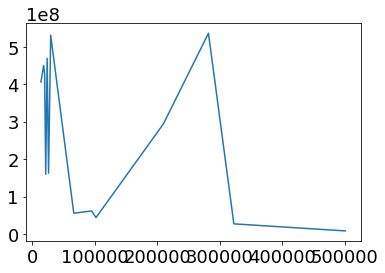

In [52]:
plt.plot(results['loss'],bayes_params['cb_buffer_size'])

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


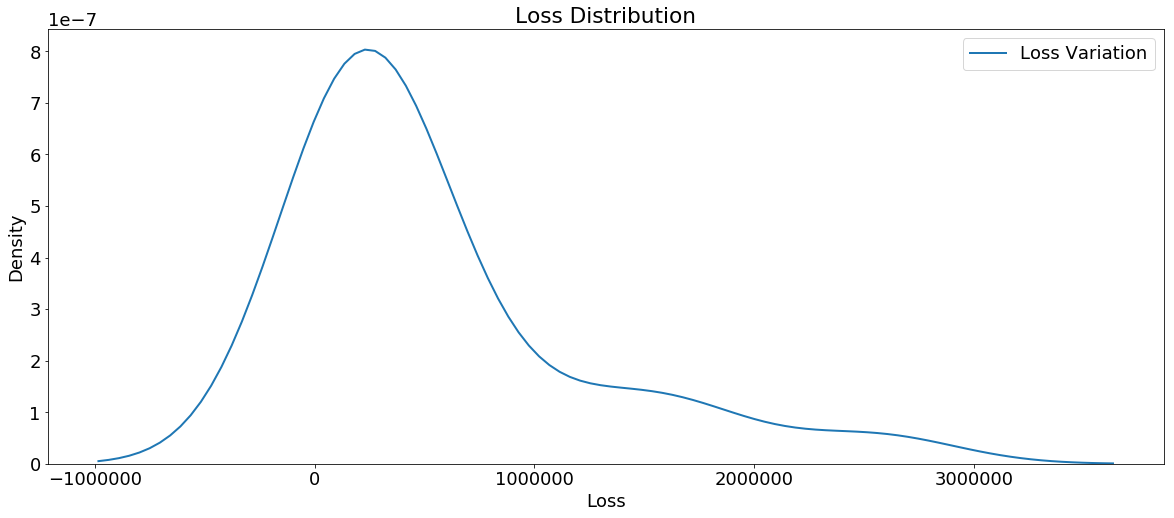

In [15]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


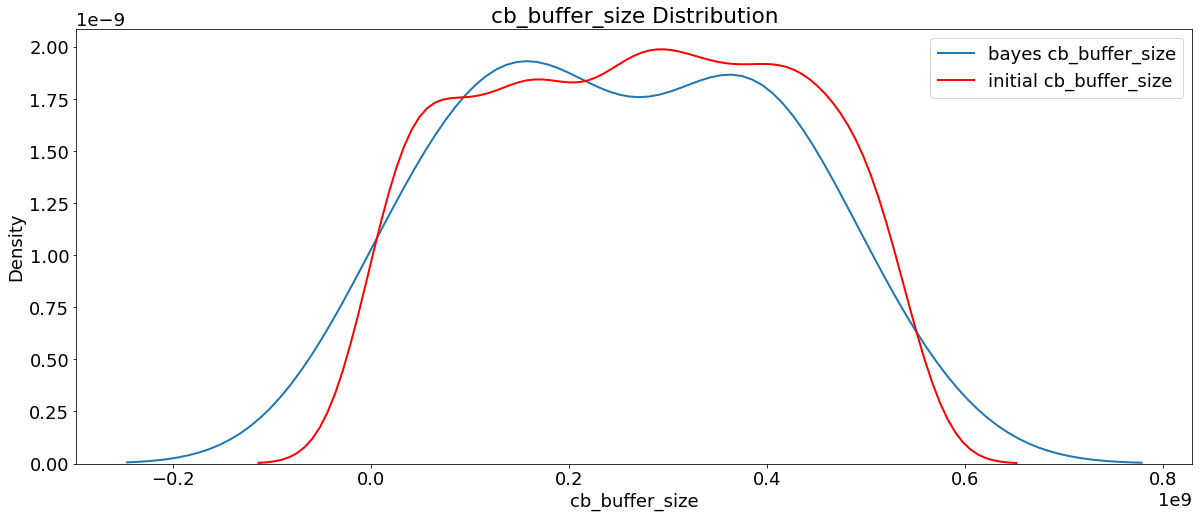

In [16]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


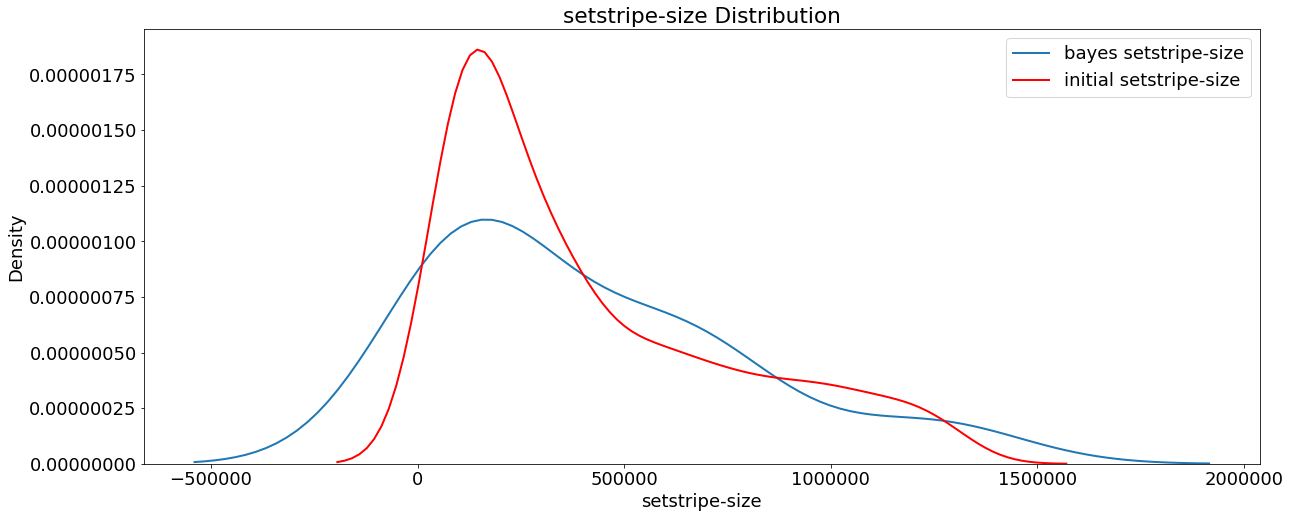

In [17]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


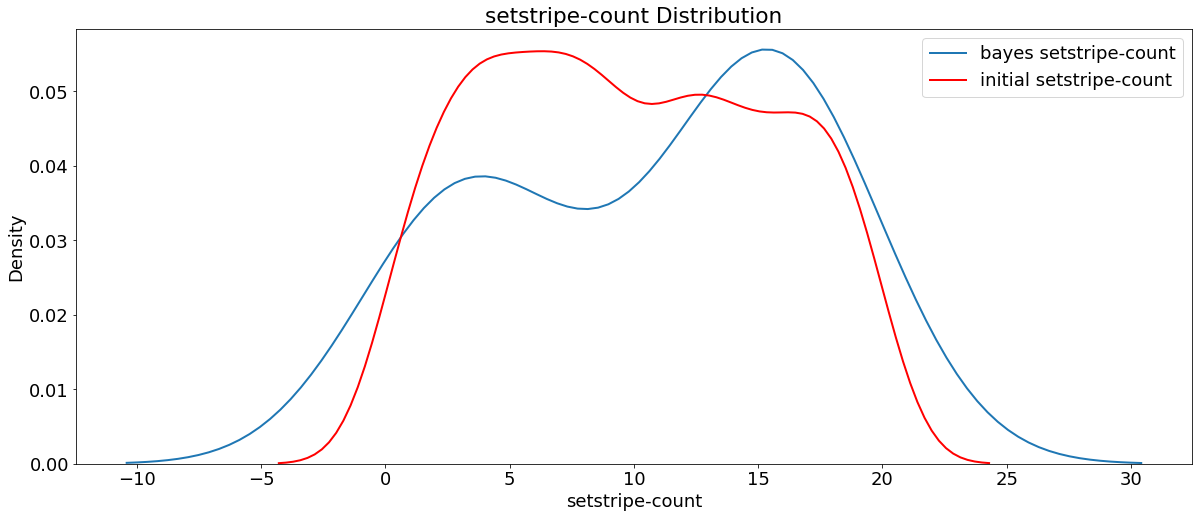

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


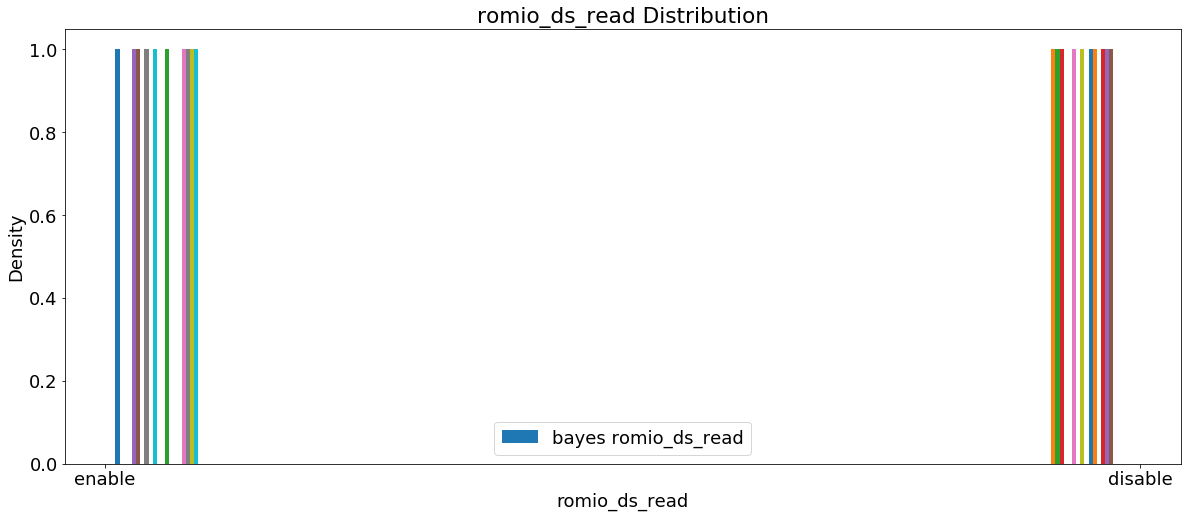

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_ds_read'], label = 'bayes romio_ds_read', linewidth = 2)
#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Density'); plt.title('romio_ds_read Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


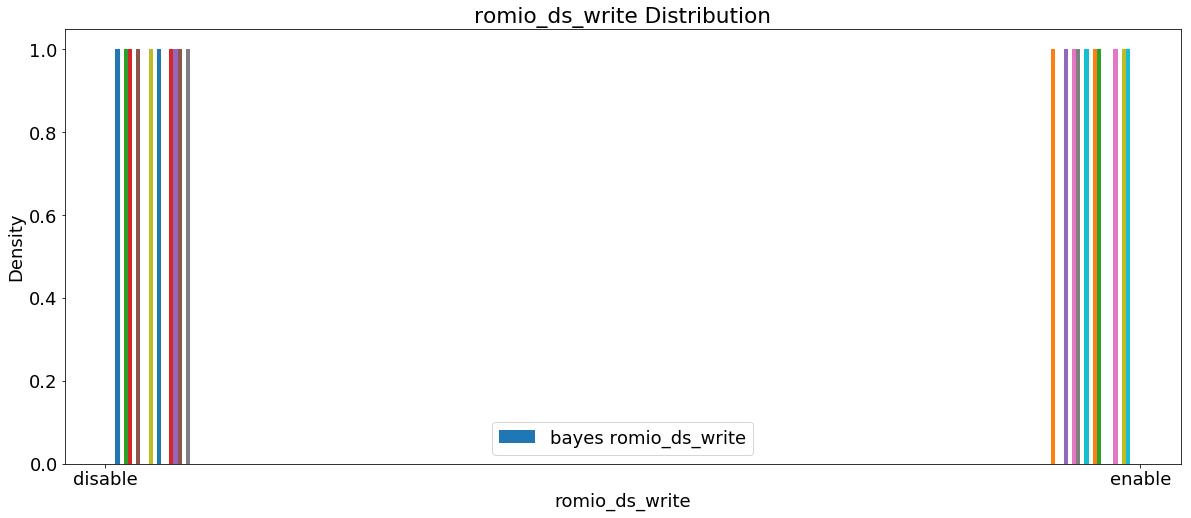

In [20]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')

plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Density'); plt.title('romio_ds_write Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


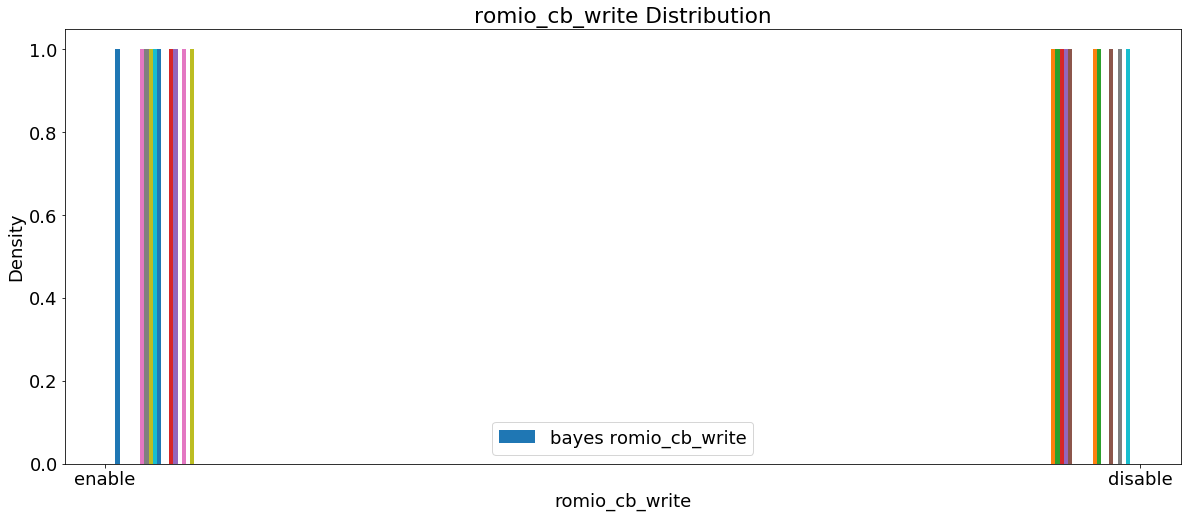

In [21]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_cb_write'], label = 'bayes romio_cb_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Density'); plt.title('romio_cb_write Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


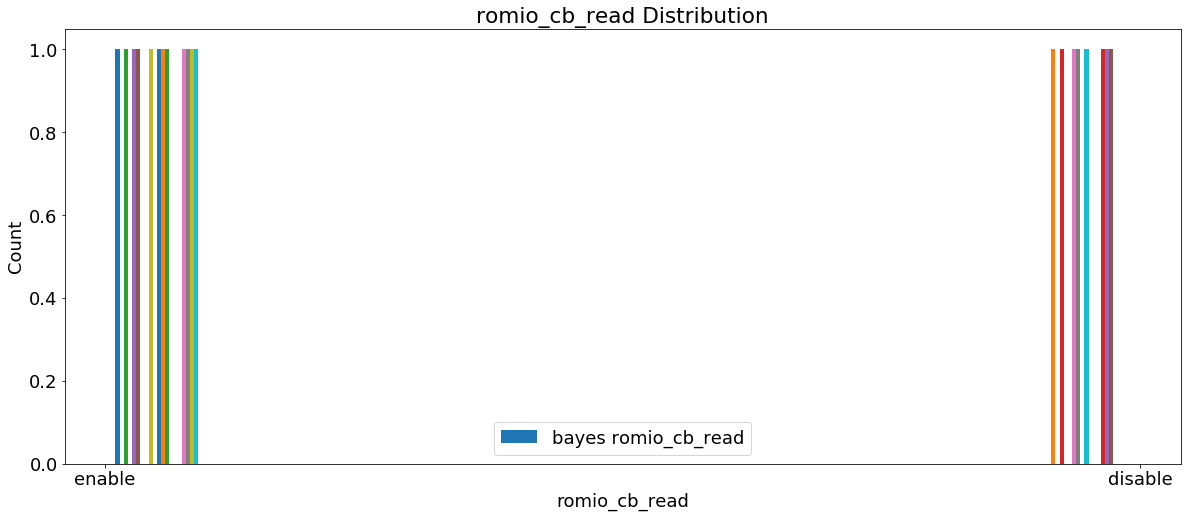

In [22]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_cb_read'], label = 'bayes romio_cb_read', linewidth = 2)
#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');